## The Premier League's Quarter Backs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats


from mplsoccer import Pitch

from PIL import Image
import urllib
import os

In [2]:
font_path = "../Grafici/assets/fonts/"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../Grafici/assets/stylesheets/soc_base.mplstyle")
plt.rcParams['font.family'] = 'Karla'

## Data

In [33]:
df = pd.read_csv('data/team_styles.csv', index_col=0)

In [34]:
'''
df = (
    df.groupby(['player_id', 'player_first_name', 'player_last_name'])
    [['minutes', 'long_balls_att', 'long_balls_succ']].sum()
    .reset_index()
)
df
'''
df

,team_id,Team,pass_per_seq,speed
0,9875,Napoli,4.56,1.24
1,8543,Lazio,4.17,1.39
2,9885,Juventus,3.57,1.49
3,8636,Inter,3.99,1.47
4,8524,Atalanta,3.32,1.59
5,8564,Milan,3.45,1.45
6,8686,Roma,3.27,1.47
7,8535,Fiorentina,3.30,1.45
8,9857,Bologna,3.72,1.29
9,6504,Monza,3.86,1.30


In [30]:
df = df.set_index('Team')

In [31]:
df.loc['Napoli']

team_id         9875.00
pass_per_seq       4.56
speed              1.24
Name: Napoli, dtype: float64

We filter players above the median in both minutes and long balls attempted.

In [101]:
df_plot = df[(df['minutes'] >= df['minutes'].median()) & (df['long_balls_att'] >= df['long_balls_att'].median())]
df_plot

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ
0,23354,Ashley,Young,693,45,21
3,37549,Joao,Moutinho,931,51,34
5,43248,Jonny,Evans,810,67,39
8,72541,César,Azpilicueta,561,22,3
10,80562,Thiago,Silva,990,107,58
...,...,...,...,...,...,...
348,1078788,Neco,Williams,1048,77,25
353,1112684,Nathan,Patterson,585,20,9
356,1120224,Tyrick,Mitchell,910,57,17
358,1137668,Moisés,Caicedo,888,42,27


In [102]:
df_plot = df_plot.assign(per_90 = lambda x: (x.long_balls_att/x.minutes)*90)
df_plot = df_plot.assign(succ_rate = lambda x: x.long_balls_succ/x.long_balls_att)

In [103]:
df_plot.sort_values(by='per_90')

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ,per_90,succ_rate
328,961995,Bukayo,Saka,907,16,12,1.587652,0.750000
159,532743,Philip,Billing,888,21,7,2.128378,0.333333
109,351860,Aleksandar,Mitrovic,803,19,12,2.129514,0.631579
181,599353,Che,Adams,797,19,16,2.145546,0.842105
154,523825,Jarrod,Bowen,1072,26,16,2.182836,0.615385
...,...,...,...,...,...,...,...,...
46,189982,Fabian,Schär,1155,135,57,10.519481,0.422222
172,568571,Joseph,Gomez,792,97,47,11.022727,0.484536
162,534684,Ruben,Neves,1170,155,97,11.923077,0.625806
246,760712,Trent,Alexander-Arnold,906,130,64,12.913907,0.492308


Now, we compute a basic z-score index for the colormap.

In [108]:
df_plot['zscore'] = stats.zscore(df_plot['per_90'])*.4 + stats.zscore(df_plot['succ_rate'])*.6
df_plot['annotated'] = [True if x > df_plot['zscore'].quantile(.8) else False for x in df_plot['zscore']]

In [107]:
df_plot[df_plot['player_last_name'] == 'Saka']

,player_id,player_first_name,player_last_name,minutes,long_balls_att,long_balls_succ,per_90,succ_rate,zscore,annotated
328,961995,Bukayo,Saka,907,16,12,1.587652,0.75,0.751087,True


In [19]:
def ax_logo(team_id, ax):
    '''
    Plots the logo of the team at a specific axes.
    Args:
        team_id (int): the id of the team according to Fotmob. You can find it in the url of the team page.
        ax (object): the matplotlib axes where we'll draw the image.
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png'))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

In [38]:
df['team_id'].to_list()

[9875,
 8543,
 9885,
 8636,
 8524,
 8564,
 8686,
 8535,
 9857,
 6504,
 9804,
 7943,
 8600,
 6480,
 8534,
 9888,
 9876,
 9881,
 7801,
 9882]

In [55]:
pass_med = df['pass_per_seq'].median()
speed_med = df['speed'].median()

## The Viz

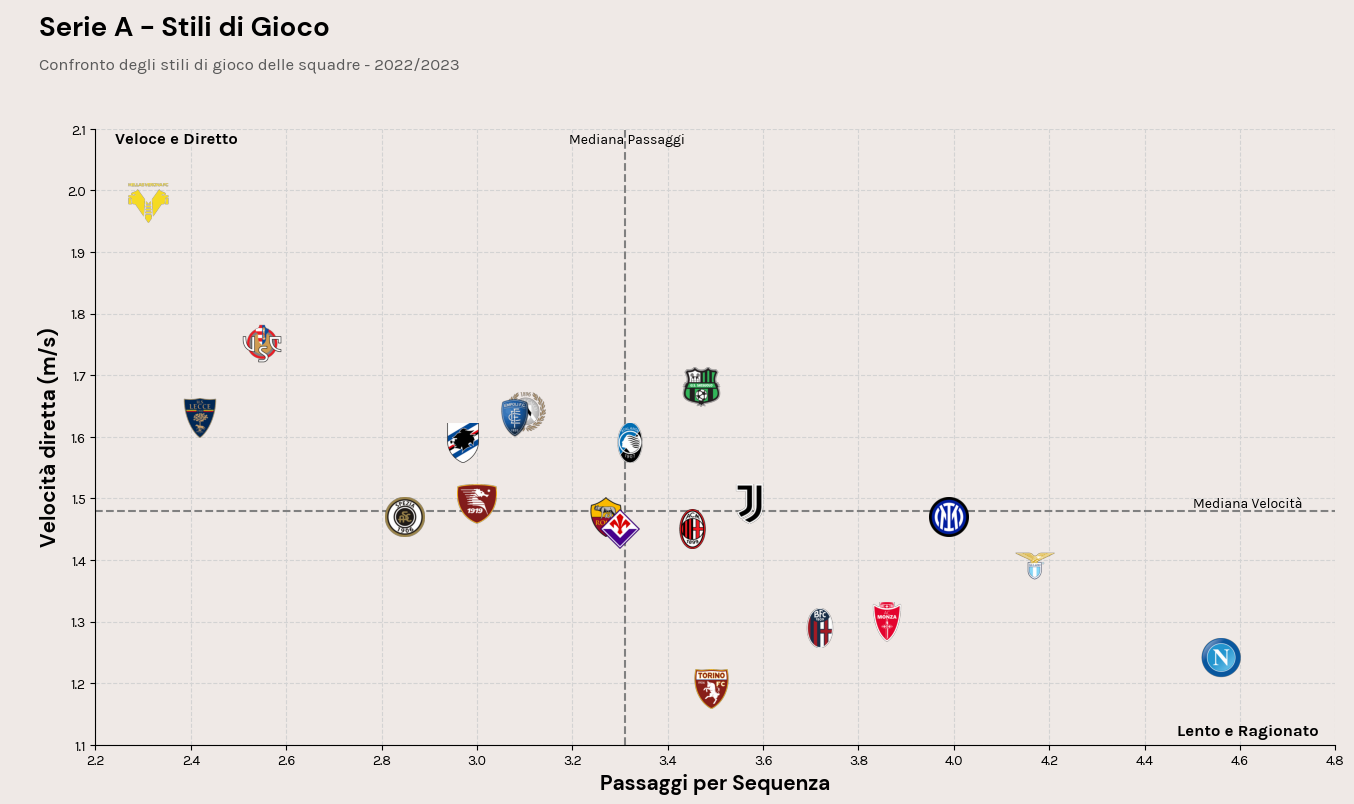

In [98]:
fig = plt.figure(figsize=(16,8), dpi=100)
ax = plt.subplot()
ax.grid(visible=True, ls='--', color='lightgrey')

ax.scatter(
    df['pass_per_seq'], df['speed'], 
    #c='blue', #cmap='inferno',
    zorder=3, ec='grey', s=55, alpha=0)

ax.annotate(
    xy=(.392,0.83),
    text='Mediana Passaggi' ,
    xycoords='figure fraction',
    ha='center',
    va='center'
)
    
ax.annotate(
    xy=(0.78,.376),
    text='Mediana Velocità' ,
    xycoords='figure fraction',
    ha='center',
    va='center'
)

ax.annotate(
    xy=(0.78, 0.09),
    text='Lento e Ragionato' ,
    xycoords='figure fraction',
    ha='center',
    va='center',
    fontsize = 12, color = "black", font = "Karla", weight = "bold"
)

ax.annotate(
    xy=(0.11, 0.83),
    text='Veloce e Diretto' ,
    xycoords='figure fraction',
    ha='center',
    va='center',
    fontsize = 12, color = "black", font = "Karla", weight = "bold"
)


texts = []
#annotated_df = df[df['annotated']].reset_index(drop=True)
'''
for index in range(df.shape[0]):
    texts += [
        ax.text(
            x=df['pass_per_seq'].iloc[index], y=df['speed'].iloc[index],
            s=f"{df['Team'].iloc[index][0]}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='DM Sans', weight='bold'
        )
    ]

adjust_text(texts, only_move={'points':'y', 'text':'xy', 'objects':'xy'})
'''
ax.xaxis.set_major_locator(ticker.MultipleLocator(.2))
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
#ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
ax.set_xlim(2.2,4.8)
ax.set_ylim(1.1,2.1)

ax.set_ylabel('Velocità diretta (m/s)', fontsize = 15, color = "black", font = "DM Sans", weight = "bold")
ax.set_xlabel('Passaggi per Sequenza', fontsize = 15, color = "black", font = "DM Sans", weight = "bold")

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

ax_size = 0.05

counter = 0
for x,y in zip(df['pass_per_seq'], df['speed']):
    ax_coords = DC_to_NFC((x,y))
    image_ax = fig.add_axes(
        [ax_coords[0] - ax_size/2, ax_coords[1] - ax_size/2, ax_size, ax_size],
         fc='None'
    )
    ax_logo(df['team_id'].to_list()[counter], image_ax)

    counter += 1

ax.axhline(y=speed_med, ls='--', color='grey')
ax.axvline(x=pass_med, ls='--', color='grey')



fig_text(
    x = 0.09, y = .99, 
    s = "Serie A - Stili di Gioco",
    va = "bottom", ha = "left",
    fontsize = 20, color = "black", font = "DM Sans", weight = "bold"
)

fig_text(
    x = 0.09, y = 0.95, 
    s = "Confronto degli stili di gioco delle squadre - 2022/2023",
    va = "bottom", ha = "left",
    fontsize = 12, color = "#5A5A5A", font = "Karla"
)

plt.savefig(
	"figures/SerieA_Team_Styles.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/SerieA_Team_Styles_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)
